In [67]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, initializers

import tensorflow_addons as tfa

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import random

from kaggle_datasets import KaggleDatasets

In [68]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


# DATASET:

In [69]:
GCS_PATH       = KaggleDatasets().get_gcs_path("gan-getting-started")

PHOTO_FILES_PATH = tf.io.gfile.glob(GCS_PATH + "/photo_tfrec/*.tfrec")
MONET_FILES_PATH = tf.io.gfile.glob(GCS_PATH + "/monet_tfrec/*.tfrec")

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 4

In [70]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [71]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [92]:
def image_aug(image):
    rotation_p = random.random()
    crop_p    = random.random()
    spacial_p = random.random()
    
    if crop_p > 2:
        image = tf.image.resize(image, size=[286,286])
        image = tf.image.random_crop(image, size=[256,256,3])
        
    if rotation_p > 2:
        image = tf.image.rot90(image, k=random.randint(1, 3))
        
    if spacial_p > 2:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if spacial_p > .9:
            image = tf.image.transpose(image)
    
    return image

In [93]:
def get_gan_dataset(photo_files, monet_files):
    photo_ds = load_dataset(photo_files)
    monet_ds = load_dataset(monet_files)
    
    photo_ds = photo_ds.repeat()
    monet_ds = monet_ds.repeat()
    
    photo_ds = photo_ds.map(image_aug,  num_parallel_calls=AUTO)
    monet_ds = monet_ds.map(image_aug,  num_parallel_calls=AUTO)
    
    photo_ds = photo_ds.shuffle(2048)
    monet_ds = monet_ds.shuffle(2048)
    
    photo_ds = photo_ds.batch(BATCH_SIZE, drop_remainder=True)
    monet_ds = monet_ds.batch(BATCH_SIZE, drop_remainder=True)
    
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.cache()
    
    photo_ds = photo_ds.prefetch(AUTO)
    monet_ds = monet_ds.prefetch(AUTO)
    
    return tf.data.Dataset.zip((photo_ds, monet_ds))

In [94]:
gan_data = get_gan_dataset(PHOTO_FILES_PATH, MONET_FILES_PATH)

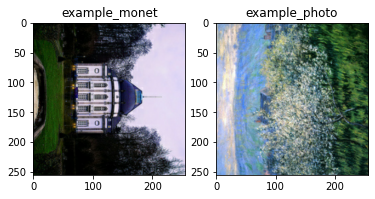

In [75]:
example_monet , example_photo = next(iter(gan_data))

plt.subplot(1, 2, 1)
plt.title("example_monet")
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("example_photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

# THE MODEL :

In [76]:
def downsample(out_ch, kernel=4, norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init =  tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(out_ch,
                            kernel_size=kernel,
                            strides=2,
                            padding="same",
                            use_bias=False,
                            kernel_initializer = initializer))
    
    if norm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))
        
    
    
    model.add(layers.LeakyReLU())
        
    return model

def upsample(out_ch, kernel=4, norm=True, drop_out=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2DTranspose(out_ch, kernel_size=kernel, strides=2, padding="same", use_bias=False, kernel_initializer=initializer,))
    
    if norm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    
    if drop_out:
        model.add(layers.Dropout(0.5))
    
    
    model.add(layers.ReLU())
        
    return model

In [77]:
def generator():
    i = tf.keras.Input(shape=(256,256,3))
    x1 = downsample(64)(i) # 128
    x2 = downsample(128)(x1) # 64
    x3 = downsample(256)(x2) # 32
    x4 = downsample(512)(x3) # 16
    x5 = downsample(512)(x4) # 8
    x6 = downsample(512)(x5) # 4
    x7 = downsample(512)(x6) # 2
    x8 = downsample(512)(x7) # 1

    o1 = upsample(512, drop_out=True)(x8) # 2
    o2 = upsample(512, drop_out=True)(layers.Concatenate()([o1, x7]))
    o3 = upsample(512, drop_out=True)(layers.Concatenate()([o2, x6]))
    o4 = upsample(512)(layers.Concatenate()([o3, x5]))
    o5 = upsample(256)(layers.Concatenate()([o4, x4]))
    o6 = upsample(128)(layers.Concatenate()([o5, x3]))
    o7 = upsample(64 )(layers.Concatenate()([o6, x2]))
#     o8 = upsample(3)(layers.Concatenate()([o7, x1]))
    out = layers.Conv2DTranspose(3, 4,
                                 strides=2,
                                 padding="same",
                                 use_bias=False,
                                 activation="tanh",
                                 kernel_initializer=tf.random_normal_initializer(0., 0.02))(layers.Concatenate()([o7, x1]))
    
    return tf.keras.Model(inputs=i, outputs=out)

In [78]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init =  tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    i = tf.keras.Input(shape=(256,256,3)) # 256 256 3
    
    x = downsample(64)(i)  # 128 128 64
    x = downsample(128)(x) # 64  64  128
    x = downsample(256)(x) # 32  32  256
    
    x = layers.ZeroPadding2D()(x) # 34 34 256
    x = layers.Conv2D(512, kernel_size=4, strides=1, use_bias=False, kernel_initializer=initializer)(x) # 31 31 512
    
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)

    x = layers.LeakyReLU()(x)

    x = layers.ZeroPadding2D()(x) # (bs, 33, 33, 512)

    x = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(x) # (bs, 30, 30, 1)
    
    return tf.keras.models.Model(inputs=i, outputs=x)
    
    

# LOSSES :

In [79]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss      = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                           reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                           reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        return (real_loss + generated_loss) * 0.4

In [80]:
with strategy.scope():
    def identity_loss(real, generated, LAMBDA=15):
        loss = tf.reduce_mean(tf.abs(real - generated))
        return LAMBDA * loss * 0.5

In [81]:
with strategy.scope():
    def cycle_loss(real, generated, LAMBDA=15):
        loss = tf.reduce_mean(tf.abs(real - generated))
        return LAMBDA * loss

In [82]:
with strategy.scope():
    def gen_loss(generated_disc):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated_disc), generated_disc)

In [83]:
class CycGAN(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator
    ):
        super(CycGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_dis = monet_discriminator
        self.p_dis = photo_discriminator   
        
        
    def compile(
        self,
        m_gen_optim,
        p_gen_optim,
        m_dis_optim,
        p_dis_optim,
        gen_loss,
        idt_loss,
        cyc_loss,
        dis_loss
    ):
        super(CycGAN, self).compile()
        self.m_gen_optim = m_gen_optim
        self.p_gen_optim = p_gen_optim
        self.m_dis_optim = m_dis_optim
        self.p_dis_optim = p_dis_optim
        self.gen_loss = gen_loss
        self.idt_loss = idt_loss
        self.cyc_loss = cyc_loss
        self.dis_loss = dis_loss
        
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            
            #Generated
            fake_monet = self.m_gen(real_photo, training=True)
            fake_photo = self.p_gen(real_monet, training=True)
            
            #Identity
            idt_monet  = self.m_gen(real_monet, training=True)
            idt_photo  = self.p_gen(real_photo, training=True)
            
            #Cycle
            cyc_monet  = self.m_gen(fake_photo, training=True)
            cyc_photo  = self.p_gen(fake_monet, training=True)
            
            #discriminator real ones:
            disc_real_monet = self.m_dis(real_monet, training=True)
            disc_real_photo = self.p_dis(real_photo, training=True)
            
            #discriminator fake ones:
            disc_fake_monet = self.m_dis(fake_monet, training=True)
            disc_fake_photo = self.p_dis(fake_photo, training=True)
            
            
            #THE LOSSES YAAAAAAAAAAAAY
            total_cycle_loss = self.cyc_loss(cyc_monet, real_monet) + self.cyc_loss(cyc_photo, real_photo)
            
            m_gen_loss = self.idt_loss(idt_monet, real_monet) + total_cycle_loss + self.gen_loss(disc_fake_monet)
            p_gen_loss = self.idt_loss(idt_photo, real_photo) + total_cycle_loss + self.gen_loss(disc_fake_photo)
            
            
            m_dis_loss = self.dis_loss(disc_real_monet, disc_fake_monet)
            p_dis_loss = self.dis_loss(disc_real_photo, disc_fake_photo)
            

        #Calcul the gradients for the gen and the disc:
        m_gen_gradients = tape.gradient(m_gen_loss, self.m_gen.trainable_variables)
        p_gen_gradients = tape.gradient(p_gen_loss, self.p_gen.trainable_variables)
        m_dis_gradients = tape.gradient(m_dis_loss, self.m_dis.trainable_variables)
        p_dis_gradients = tape.gradient(p_dis_loss, self.p_dis.trainable_variables)

        #Applay the gradients COOOOOOOL
        self.m_gen_optim.apply_gradients(zip(m_gen_gradients, self.m_gen.trainable_variables))
        self.p_gen_optim.apply_gradients(zip(p_gen_gradients, self.p_gen.trainable_variables))
        self.m_dis_optim.apply_gradients(zip(m_dis_gradients, self.m_dis.trainable_variables))
        self.p_dis_optim.apply_gradients(zip(p_dis_gradients, self.p_dis.trainable_variables))


        return {
                "monet_gen_loss": m_gen_loss,
                "photo_gen_loss": p_gen_loss,
                "monet_disc_loss": m_dis_loss,
                "photo_disc_loss": p_dis_loss
            }

In [84]:
with strategy.scope():
    monet_generator = generator()
    photo_generator = generator()    
    monet_discriminator = discriminator()
    photo_discriminator = discriminator()    
    
    m_gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, decay=0, beta_1=0.5)
    p_gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5)    
    m_dis_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5)    
    p_dis_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5)    

In [85]:
with strategy.scope():
    cyc_gan_model = CycGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    cyc_gan_model.compile(
                m_gen_optim = m_gen_optimizer,
                p_gen_optim = p_gen_optimizer,
                m_dis_optim = m_dis_optimizer,
                p_dis_optim = p_dis_optimizer,
                gen_loss    = gen_loss,
                idt_loss    = identity_loss,
                cyc_loss    = cycle_loss,
                dis_loss    = discriminator_loss
    )

In [86]:
cyc_gan_model.fit(
    gan_data,
    epochs=30,
    steps_per_epoch=(7038//4),
)

Epoch 1/30
1759/1759 [==============================] - 343s 130ms/step - monet_gen_loss: 8.0660 - photo_gen_loss: 7.9671 - monet_disc_loss: 0.4996 - photo_disc_loss: 0.5284
Epoch 2/30
1759/1759 [==============================] - 228s 130ms/step - monet_gen_loss: 6.7132 - photo_gen_loss: 6.6252 - monet_disc_loss: 0.4830 - photo_disc_loss: 0.5157
Epoch 3/30
1759/1759 [==============================] - 228s 130ms/step - monet_gen_loss: 5.8023 - photo_gen_loss: 5.7458 - monet_disc_loss: 0.4741 - photo_disc_loss: 0.4941
Epoch 4/30
1759/1759 [==============================] - 229s 130ms/step - monet_gen_loss: 5.2742 - photo_gen_loss: 5.1597 - monet_disc_loss: 0.4574 - photo_disc_loss: 0.4878
Epoch 5/30
1759/1759 [==============================] - 228s 130ms/step - monet_gen_loss: 5.0574 - photo_gen_loss: 4.9093 - monet_disc_loss: 0.4331 - photo_disc_loss: 0.4833
Epoch 6/30
1759/1759 [==============================] - 227s 129ms/step - monet_gen_loss: 5.0740 - photo_gen_loss: 5.1230 - monet_

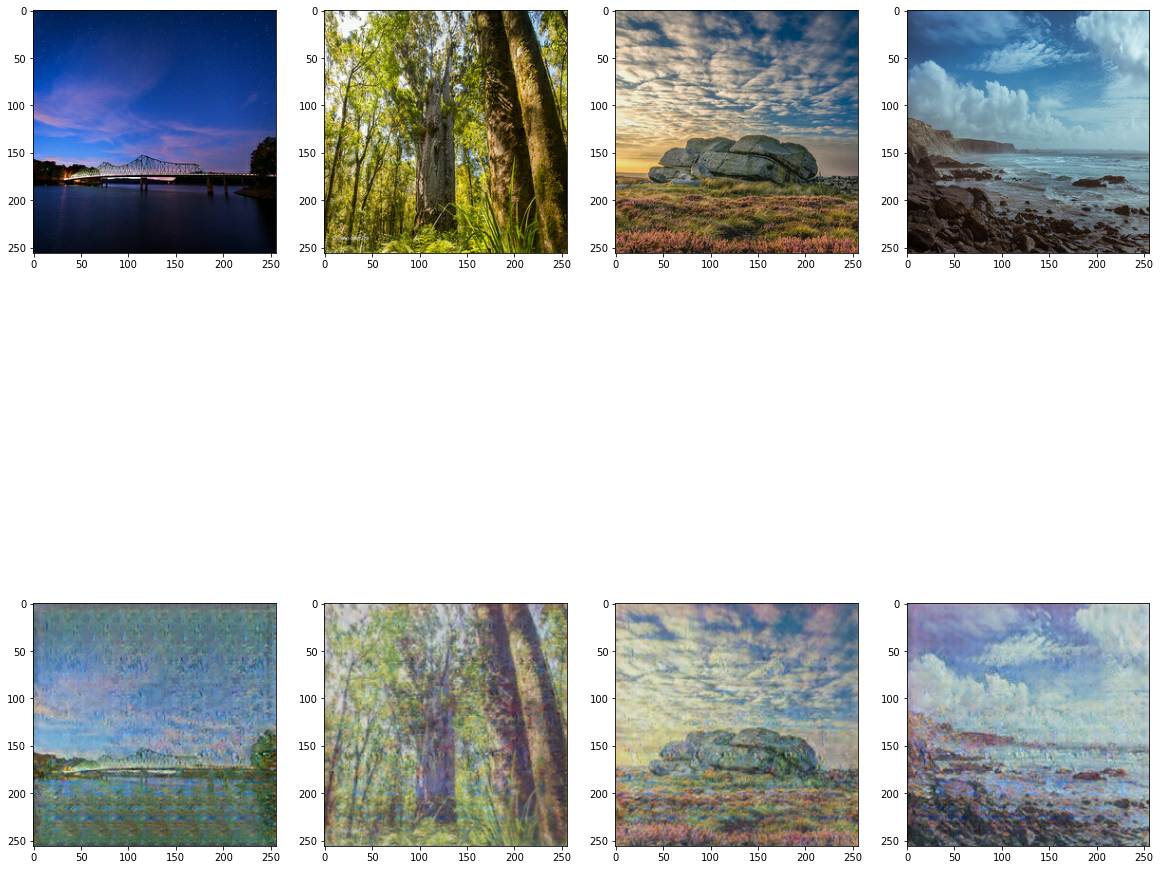

In [117]:
example_photo, example_monet = next(iter(gan_data))

plt.figure(figsize=(20,20))

plt.subplot(2, 4, 1)
plt.imshow(example_photo[0] * 0.5 + 0.5)
plt.subplot(2, 4, 2)
plt.imshow(example_photo[1] * 0.5 + 0.5)
plt.subplot(2, 4, 3)
plt.imshow(example_photo[2] * 0.5 + 0.5)
plt.subplot(2, 4, 4)
plt.imshow(example_photo[3] * 0.5 + 0.5)

out = cyc_gan_model.p_gen(example_photo)

plt.subplot(2, 4, 5)
plt.imshow(out[0] * 0.5 + 0.5)
plt.subplot(2, 4, 6)
plt.imshow(out[1] * 0.5 + 0.5)
plt.subplot(2, 4, 7)
plt.imshow(out[2] * 0.5 + 0.5)
plt.subplot(2, 4, 8)
plt.imshow(out[3] * 0.5 + 0.5)

In [114]:
out = cyc_gan_model.p_gen(example_photo)

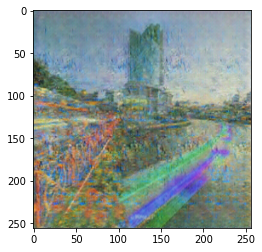

In [108]:
plt.imshow(out[0] * 0.5 + 0.5)

In [118]:
import PIL
! mkdir ../images

In [119]:
import os

In [ ]:
"/kaggle/images/"

In [137]:
i = 0
for photo, monet in iter(gan_data):
    out = cyc_gan_model.p_gen(photo)
    for p in range(len(out)):
        prediction = out[p]
        prediction = (prediction * 127.5 + 127.5).numpy().astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save(f'/kaggle/images/{str(i)}.jpg')
        i += 1
        if i % 100 == 0:
            print(i)
print("labas")

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100


KeyboardInterrupt: 

In [173]:
len(os.listdir('1efdfce7c3.jpg'))

FileNotFoundError: [Errno 2] No such file or directory: '1efdfce7c3.jpg'

In [186]:
img = PIL.Image.open("/kaggle/input/gan-getting-started/photo_jpg/c47e602b0b.jpg")

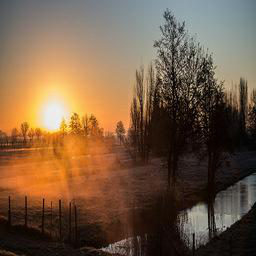

In [187]:
img

In [188]:
img_ = (np.array(img) / 255 - 0.5)
out = cyc_gan_model.p_gen(np.expand_dims(img_, axis=0))

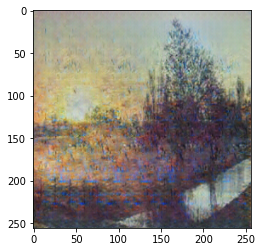

In [189]:
plt.imshow((out[0] * 127.5 + 127.5).numpy().astype(np.uint8))

In [198]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

In [190]:
! mkdir ../images2

In [197]:
! rm -r ../images2

In [195]:
i = -1
L = os.listdir("/kaggle/input/gan-getting-started/photo_jpg/")
for img_path in L:
    img = PIL.Image.open("/kaggle/input/gan-getting-started/photo_jpg/"+img_path)
    img_ = (np.array(img) / 255 - 0.5)
    out = cyc_gan_model.p_gen(np.expand_dims(img_, axis=0), training=False  )[0].numpy().astype(np.uint8)
    im = PIL.Image.fromarray(out)
    im.save(f'/kaggle/images2/{str(i)}.jpg')
    i += 1
    if i % 100 == 0:
        print(i)
    

0
100
200


KeyboardInterrupt: 